# 📜 NLP Going Deeper : seq2seq로 번역기 만들기 📜

NLP Going Deeper 이전 노드에서 살펴본 seq2seq를 활용해서 번역기를 만드는 프로젝트를 수행합니다.

**seq2seq는 2개의 RNN 모듈을 Encoder-Decoder 구조로 결합한 모델입니다.**

우선 아래와 같이 디렉토리를 만든 후, 한국어를 잘 시각화하고 올바른 Attention Map을 확인할 수 있도록 한국어를 지원하는 폰트로 바꾸어 줍니다.

아래 명령어의 **첫 줄은 디렉토리를 생성해주며, 두 번째 줄은 나눔 글꼴을 설치**해주는 명령어입니다. 😉😉

참고로 설치된 글꼴이 작업 과정에서 잘 보이기 위해서 LMS 시스템을 재구동시키는 작업이 권장됩니다!

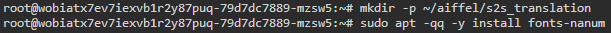

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

print("더 높이 날아올라가~🛸")

더 높이 날아올라가~🛸


우선, 노드에서 소개하고 있는 영어-스페인어 말뭉치를 사용한 번역기를 만들며 익혀보겠습니다.

## 데이터 전처리 - 데이터 준비하기

필요한 라이브러리를 불러옵니다

In [2]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

print('지금 텐서플로우 버전이', tf.__version__ ,'이군요! 좋은 툴 쓰고 계시네요..😅')

지금 텐서플로우 버전이 2.4.1 이군요! 좋은 툴 쓰고 계시네요..😅


한편, 텐서플로우에서는 **tf.keras.utils.get_file()** 이라는 메서드가 있습니다.

get_file() 은 URL로부터 데이터를 다운로드 받을 수 있게 하고, 압축된 형식이라면 압축 해제까지 수행해 주는 스마트한 함수입니다!

해당 메서드를 활용하여 데이터를 다운로드 해봅시다. 😎

In [3]:
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip',
    origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

정상적으로 다운로드되었다면, 읽어와서 그 형태를 확인해볼 수 있겠습니다.

In [4]:
with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("다운로드 받은 데이터의 Size는", len(raw), '개나 되네요..😅')
print("형태는 다음과 같이 생겼어요.")

for sen in raw[0:100][::20]: print(">>", sen)

다운로드 받은 데이터의 Size는 118964 개나 되네요..😅
형태는 다음과 같이 생겼어요.
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


## 데이터 전처리 - 데이터 정제하기

스페인에서는 **역 물음표(¿)와 역 느낌표(¡)를 일반적으로 사용합니다.**

스페인어 문장이 물음표나 느낌표로 끝난다면 해당 문장 맨 앞에 역으로 된 기호를 붙여준다고 합니다.

여기에서는 이해를 돕기 위해 위 특수문자들을 불필요한 노이즈로 작용할 수 있는 문자로 보고 정제 과정에서 삭제하도록 합니다.

위 제약사항을 적용한 정제는 아래와 같이 할 수 있습니다

In [5]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("정제 완료✔")

정제 완료✔


위의 코드를 살펴보면, start 토큰과 end 토큰이 있는데, 이는 각각 문장의 시작과 끝을 나타냅니다.

Encoder에 들어갈 입력 문장의 전처리에는 굳이 필요하지 않지만, **Decoder의 입력 문장과 라벨로 사용할 출력 문장의 전처리에는 꼭 필요합니다!**

나중에 뒤에서 이어질 프로젝트와 현재 데이터의 원활한 학습을 위해 **상위 25000개**의 데이터만 사용하겠습니다.

노드에서는 상위 30000개의 데이터를 사용했는데, 데이터를 얼마나 사용하느냐에 따라 훈련 데이터와 검증 데이터의 size가 달라질 수 있습니다.

In [6]:
enc_corpus = []
dec_corpus = []

num_examples = 25000

for pair in raw[:num_examples]:
    eng, spa = pair.split("\t")

    enc_corpus.append(preprocess_sentence(eng))
    dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English:", enc_corpus[100])   # go away !
print("Spanish:", dec_corpus[100])   # <start> salga de aqu ! <end>

English: go away !
Spanish: <start> salga de aqu ! <end>


## 데이터 전처리 - 토큰화

이전 스텝에서 정제된 텍스트를 아래 **tokenize()** 함수를 사용해 토큰화 및 텐서 변환을 실행하고, 훈련 데이터와 검증 데이터를 나누는 코드입니다.

참고. **padding='post'** : 뒤에서부터 패딩을 채우는 방식 (↔ padding='pre')

In [7]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

훈련 데이터와 검증 데이터는 일반적인 분리 기준을 따르기로 하겠습니다. (**8:2**)

In [8]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Spanish Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 4325
Spanish Vocab Size: 7876


## 모델 설계

아래 구조에 입각하여, **인코더와 디코더가 각각 1개의 GRU를 갖는 구조**를 가진 모델을 설계합니다

여기서 GRU가 무엇인지 알고 싶다면 여기에서 살펴보면 좋겠습니다. (https://blog.naver.com/beyondlegend/222510332412)

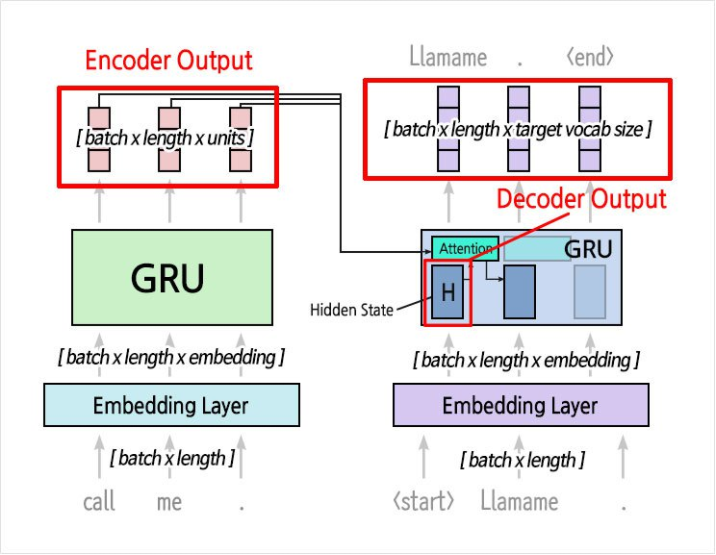

Encoder는 모든 Time-Step의 Hidden State를 출력으로 갖고, Decoder는 Encoder의 출력과 Decoder의 t-1 Step의 Hidden State로 Attention을 취하여 t Step의 Hidden State를 만들어 냅니다.

Decoder에서 t Step의 단어로 예측된 것을 실제 정답과 대조해 Loss를 구하고, 생성된 t Step의 Hidden State는 t+1 Step의 Hidden State를 만들기 위해 다시 Decoder에 전달됩니다.

여기서 't=1 일 때의 Hidden State는 어떻게 정의할 것인가?' 가 궁금하실 수 있는데요, 일반적으로 Encoder의 Final State를 Hidden State로 사용합니다.

Attention의 경우에는 Bahdanau Attention을 사용하게 될 것입니다.

혹시, Bahdanau Attention이 궁금하시다면 여기로 가서 알아봅시다~ (https://wikidocs.net/73161)

In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("탄탄하게 설계되었겠지요! 😎")

탄탄하게 설계되었겠지요! 😎


위의 예시 그림과 동일한 구조를 갖는 Encoder 클래스를 설계합니다.

In [10]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

마찬가지로 Decoder 클래스도 설계합니다.

In [11]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

이제 결과를 출력해 봅시다.

In [12]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 7877)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## 모델 훈련 - Optimizer, Loss

이제 모델 훈련으로 넘어왔습니다.

사실, 지금까지는 fit() 함수로 간편하게 학습을 진행해 왔을 것입니다.

**하지만, 앞에서 설계한 모델은 Encoder-Decoder 구조를 갖고 있었죠?😂** 이러한 구조를 가진 모델일 경우 입출력이 단순하지 않아 학습 과정을 직접 정의해야 할 필요가 있습니다.

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("무사하셨군요~🛸")

무사하셨군요~🛸


**Optimizer는 모델이 학습할 때에 정답을 찾아가는 방법을 나타낸다고 합니다. 일반적으로 Adam을 많이 사용합니다.**

다른 Optimizing 방법도 있기는 하지만, 학습의 효율 등을 고려하는 것도 중요하니까 저희는 그냥 Adam 쓰도록 하겠습니다. 😊😊

**Encoder-Decoder 구조를 가진 모델에서는 fit() 함수를 사용할 수 없습니다. 그 이유는 바로 Loss 함수 때문입니다.**

더 자세히 설명하면, Encoder-Decoder 구조는 학습 과정이 일반적이지 않으므로 직접 Loss를 커스텀해서 사용해야 하기 때문입니다. 😭😭

**SparseCategoricalCrossentropy() 함수는 모델이 출력한 확률 분포와 (One-hot이 아닌) 정수 인덱스 답안을 비교해 Cross Entropy값을 구해 줍니다.**

예를 들어, CategoricalCrossentropy()라면 [ 0.1, 0.2, 0.7 ] 과 One-hot 인코딩된 라벨 [0, 0, 1] 을 비교하여 점수를 채점하는데,

SparseCategoricalCrossentropy() 함수라면 [ 0.1, 0.2, 0.7 ] 과 인코딩 라벨이 1인 정수 인덱스 답안 2를 비교하여 점수를 채점하게 됩니다.

또한, from_logits 는 확률 분포가 Softmax를 거쳐서 들어오는지, 모델의 출력값 그대로 들어오는지를 결정합니다.

우리는 **True로 줬으니 모델의 출력값을 그대로 전달하면 됩니다.** 그럼 False이면 Softmax 활성화 함수를 거쳐서 전달되게 되겠죠? 😎😎

tokenize() 함수 내부에 있는 **pad_sequences() 는 데이터를 한 번에 처리하기 위해 가장 긴 문장을 기준삼아 패딩 작업을 할 수 있게 해줍니다.**

만약 모델에게 PAD 토큰이 패딩을 위한 토큰이라고 명시하지 않으면 모델은 데이터의 굉장히 많은 부분이 PAD 로 이뤄져 있다고 생각하게 됩니다. 쉽게 말해 유난히 같은 답이 많은 객관식 시험이라고나 할까요...? 어떤 시험이 한 번호로만 찍어도 80점 이상을 받을 수 있다면 그 시험은 공부를 절대 하지 않겠죠! 모델은 심지어 10,000개의 정답이 넘게 있는 고난도의 문제를 풀고 있기 때문에 패딩에 대한 처리를 해주지 않으면 PAD 토큰만을 생성할 확률이 굉장히 높아집니다.

이것은 종종 발생하는 문제입니다. mask는 이러한 문제를 방지하기 위해 사용합니다. **mask는 정답지에서 PAD 토큰을 찾아내어 그 부분에 대한 Loss는 구하지 않도록 하는 역할을 해줍니다.**

**equal() 함수에 정확히는 0 이 아닌 PAD 토큰의 인덱스를 전달하는 것이 맞지만, 대부분의 경우는 0으로 패딩**되기 때문에 편의상 0을 전달하여 처리하도록 하겠습니다.

## 모델 훈련 - train_step 구현

**train_step()** 은 학습에 필요한 것을 모두 가져가 Loss를 계산한 후 반환하는 함수입니다

In [14]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("train_step 구현 완료!😍")

train_step 구현 완료!😍


**@tf.function 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줍니다.**

여기서 첫 번째 Epoch가 다른 Epoch보다 약간의 시간이 더 걸리는데, 데코레이터가 붙은 함수를 GPU에 등록하는 과정이 포함되어 있기 때문입니다.

만일 @tf.function 를 제거할 경우, Epoch당 1.5~2배 이상 더 많은 시간이 소요되기 때문에, 가능하다면 사용하는 것이 학습의 효율을 더 좋게 할 수 있습니다!

**참고 : https://www.tensorflow.org/guide/function?hl=ko**

**tf.GradientTape()는 학습하며 발생한 모든 연산을 기록하는 일종의 테이프와 같습니다.**

이것은 모델이 각 스텝의 최종 단계에서 미분값을 구하는 데에 사용됩니다.

**참고 : https://www.tensorflow.org/guide/autodiff?hl=ko**

**train_step은 다음과 같은 학습 과정을 거치게 됩니다.**
1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 을 생성
2. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. (h_dec = enc_out[:, -1])
3. Decoder에 입력으로 전달할 start 토큰 문장 생성
4. start 문장과 enc_out, Hidden State를 기반으로 다음 단어(t=1)를 예측(pred)
5. 예측된 단어와 정답 간의 Loss를 구한 후, t=1의 정답 단어를 다음 입력으로 사용 (예측 단어는 다음 입력에 사용하지 않음)
6. 위 1~5번까지의 과정을 반복

## 모델 훈련 - 본격 훈련

**tqdm은 훈련의 진행 과정을 한눈에 볼 수 있게 해주는 라이브러리입니다.**

**# tqdm**이 붙은 라인은 모두 출력에 관련된 내용입니다. 더 궁금하시면 아래 github 자료를 참고하시면 될 것 같습니다

**참고 : https://github.com/tqdm/tqdm**

In [15]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch  5: 100%|██████████| 313/313 [01:23<00:00,  3.77it/s, Loss 0.3458]


먼저 EPOCHS = 8 만큼 반복하는 루프에 진입한 후, 각 배치의 시작 인덱스(0)를 idx_list 배열에 저장합니다.

그리고 모델이 학습을 원활하게 할 수 있도록 데이터를 섞어주려고 하는데, 인덱스를 섞어서 처리할 것입니다.

**순차적인 인덱스로 데이터를 불러오는 게 아닌 랜덤한 인덱스로 데이터를 불러오는 것은 데이터를 섞는 것과 동일한 효과를 줄 수 있을 겁니다!**

그 후에 **각 미니배치를 train_step() 함수에서 학습**합니다.

train_step()은 학습에 필요한 것은 모두 가져가 Loss를 계산한 후 반환하는 함수라고 train_step 구현 부분에서 언급했습니다.

Encoder-Decoder 구조의 학습 방법을 익히는 단계라고 생각하시면 될 것 같습니다. optimizer와 loss, train_step()까지 정의한 후 훈련을 진행하면 (정확히는 위의 코드 실행이 완료되면) 그에 대한 결과를 확인할 수 있습니다.. 💙💙

### 응용하기

**Q. Step 1에서 분리한 Validation Set을 사용하는 eval_step() 함수를 정의하세요! 그리고 train_step() 을 마친 후, 곧이어 eval_step() 을 진행하도록 소스를 수정하세요! 결과는 아래와 같은 형태가 되어야 합니다.**

**❗❗주의사항❗❗ : Evaluation 중에는 모델이 학습을 하면 안된다.**

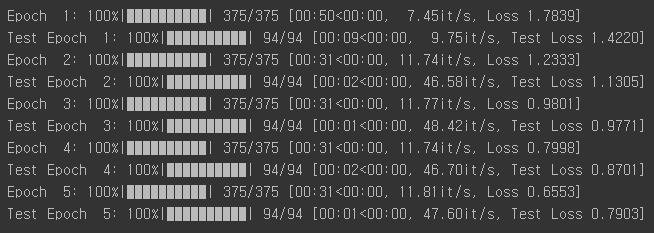

In [16]:
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

In [17]:
# Training Process

from tqdm import tqdm

EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(enc_val[idx:idx+BATCH_SIZE],
                                    dec_val[idx:idx+BATCH_SIZE],
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch  5: 100%|██████████| 79/79 [00:07<00:00,  9.93it/s, Test Loss 0.6916]


이렇게 훈련을 마친 모델은 번역 성능을 평가하기 위해 시각화를 통해 확인해 볼 수 있겠습니다.

Attention Map을 시각화하는 것도 아래 코드로 가능합니다! 😉😉😉

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


Input: i ll find someone like you .
Predicted translation: le llevar a ti a ti . <end> 


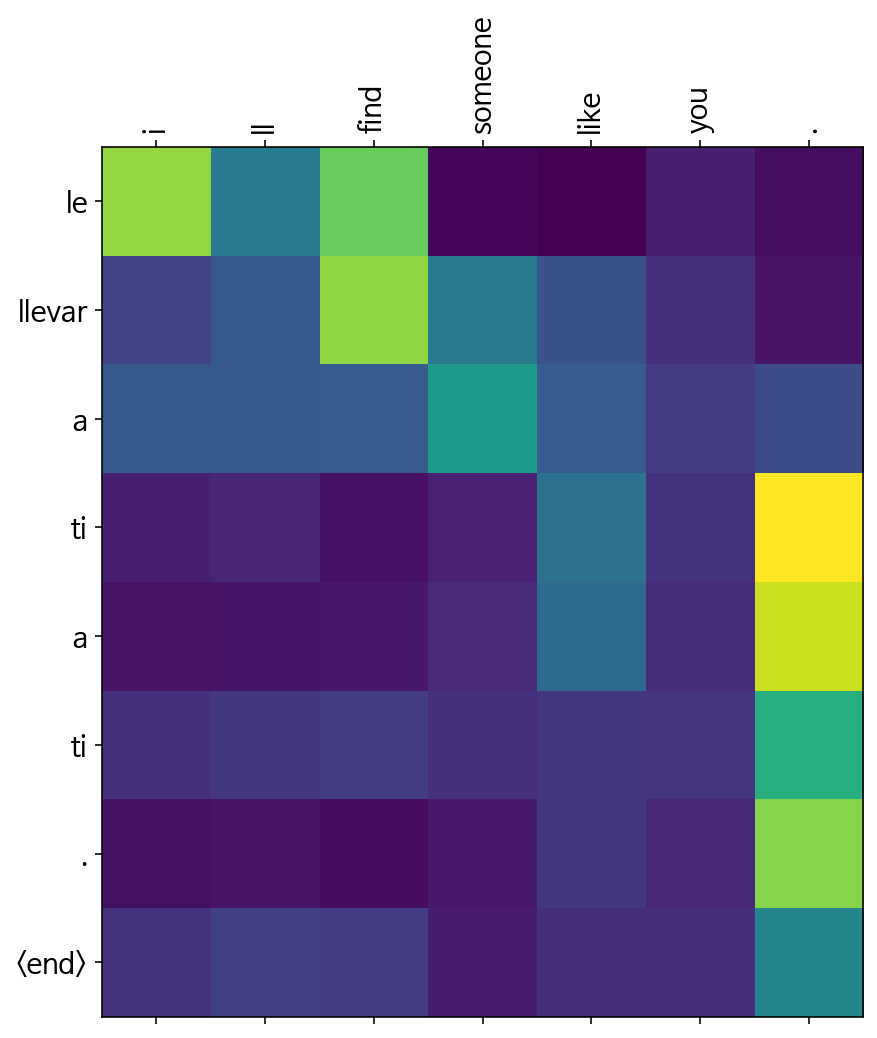

In [18]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("I'll find someone like you.", encoder, decoder)

**모델이 뱉어낸 스페인어를 해석해 보니, 아쉬운 결과가 도출된 것 같습니다.. 😭 (구글 번역기의 힘을 빌렸습니다..)**

**이는 like라는 단어가 여러 가지 뜻을 담고 있는 것과도 어느 정도 연관이 있지 않을까 생각해 봅니다!**

- 모델이 뱉어낸 스페인어 해석 : 당신이 좋아하는 것을 찾으십시오.
- 실제 영어 문장 해석 : 나는 당신과 같은 사람을 찾을 것입니다.

# 📑 프로젝트 미션 : 한국어-영어 번역기 만들기 📑

## 필요 라이브러리 로드

In [19]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

import time
import re
import os
import io

from konlpy.tag import Mecab
from tqdm import tqdm    # tqdm
import random

## 데이터 가져와서 살펴보기

아래 데이터를 통해 **한국어 데이터와 영어 데이터는 각각 96123개**가 있음을 알 수 있습니다.

위 값은 각 언어별 훈련 데이터와 검증 데이터의 합으로 볼 수 있습니다.

### 한국어 훈련 데이터

In [20]:
path_to_file = os.getenv('HOME') + '/aiffel/s2s_translation/train.ko'

with open(path_to_file, "r") as f:
    raw_train_ko = f.read().splitlines()

print("Data Size:", len(raw_train_ko))

print("Example:")
for sen in raw_train_ko[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


### 영어 훈련 데이터

In [21]:
path_to_file = os.getenv('HOME') + '/aiffel/s2s_translation/train.en'

with open(path_to_file, "r") as f:
    raw_train_en = f.read().splitlines()

print("Data Size:", len(raw_train_en))

print("Example:")
for sen in raw_train_en[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.


### 한국어 검증 데이터

In [22]:
path_to_file = os.getenv('HOME') + '/aiffel/s2s_translation/test.ko'

with open(path_to_file, "r") as f:
    raw_test_ko = f.read().splitlines()

print("Data Size:", len(raw_test_ko))

print("Example:")
for sen in raw_test_ko[0:100][::20]: print(">>", sen)

Data Size: 2000
Example:
>> 토론에 참여한 사람들은 법 집행과 국가 안전보장에 대한 우려를 표명해야 할 필요성을 진지하게 받아 들이고 있습니다.
>> 비록 그 위협(의 가능성)은 적지만, 그 잠재적인 영향력은 가히 파괴적인 것이다.
>> 한국은 세계 에서 네번째로 원유를 많이 수입하는 나라이며, 전적으로 원유 수입에 의존하고 있다.
>> 불과 1,379년 전이다.
>> 대신, 그들은 "안정"이라는 면에서 서방 세계와 똑같은 이해 관계를 갖고 있는 각 지역의 소수 엘리트를 대표하고 있다.


### 영어 검증 데이터

In [23]:
path_to_file = os.getenv('HOME')+'/aiffel/s2s_translation/test.en'

with open(path_to_file, "r") as f:
    raw_test_en = f.read().splitlines()

print("Data Size:", len(raw_test_en))

print("Example:")
for sen in raw_test_en[0:100][::20]: print(">>", sen)

Data Size: 2000
Example:
>> Those involved in the discussions do take seriously the need to address concerns of law enforcement and national security.
>> Even though the threat is small, the potential effects are devastating.
>> South Korea is the world's fourth largest oil importer and wholly depends on imports of crude.
>> That is only 1,379 years ago.
>> Instead, they represent a small elite in each place that has a common interest with the West in “stability.”


## 데이터 정제하기

**한국어-영어 번역기의 데이터 정제는 크게 다음과 같은 방법을 따릅니다.**

1. set 데이터형이 중복을 허용하지 않는다는 것을 활용해 중복된 데이터를 제거하는데, 이 때 데이터의 병렬 쌍이 흐트러지지 않도록 합니다.
2. 중복을 제거한 데이터를 cleaned_corpus 에 저장합니다.
3. 앞서 정의한 preprocessing() 함수는 한글에서는 동작하지 않으므로, 한글에 적용할 수 있는 정규식을 추가하여 함수를 재정의해야 합니다.
4. 타겟 언어인 영문엔 start 토큰과 end 토큰을 추가하고 split() 함수를 이용하여 토큰화 진행하면 됩니다.
5. 한글 토큰화는 KoNLPy의 mecab 클래스를 사용합니다. 설치가 안 되어 있다면 아래 참고 링크를 따라 설치를 진행합니다.

**KoNLPy 설치 참고 : https://konlpy.org/ko/latest/install/#ubuntu**

KoNLPy를 설치해 보셨다면 설치과정이 생각보다 꽤 걸렸을 것입니다.

아마도 거기에 있는 모든 데이터를 사용한다면 학습이 매우 오래 걸릴 것 같아 보입니다.

그래서 본 프로젝트에서는 **cleaned_corpus로부터 토큰의 길이가 44 이하인 데이터를 선별하여 eng_corpus와 kor_corpus를 각각 구축합니다.**

In [24]:
cleaned_corpus = list(set(zip(raw_train_ko, raw_train_en)))
print(cleaned_corpus[0:3], '\n')
print('정제된 한영 코퍼스 개수는', len(cleaned_corpus), '개 입니다')

[('콜롬비아 정부군의 공격으로 FARC의 2인자인 라울 레예스가 피살된 바 있다.', 'The dead included Luis Edgar Devia Silva, known as "Raul Reyes," the second-in-command of the leadership council of the Revolutionary Armed Forces of Colombia, or FARC in its Spanish acronym.'), ('휴이트는 지난 2001년 US 오픈과 그 다음해 윔블던 대회를 제패했다. 그는 테니스 역사상 가장 젊은 나이에 세계 랭킹 1위로 시즌을 마감한 경력을 가지고 있다.', 'Hewitt won the U.S. Open in 2001 and Wimbledon the following season and was the youngest man in history to finish a year ranked number one in the world.'), ('내 블로그에 저장 印 타지마할 호텔 회장 `테러 사전 경고 있었다`', "He did not elaborate on the hotel's warning or when the security measures were enacted.")] 

정제된 한영 코퍼스 개수는 78968 개 입니다


In [25]:
def preprocess_sentence_ko(sentence, s_token=False, e_token=False):
    mecab = Mecab()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^ㄱ-ㅎ|가-힣?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = mecab.morphs(sentence) # mecab으로 토큰화
    
    return sentence

In [26]:
def preprocess_sentence_en(sentence, s_token=True, e_token=True):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    sentence = sentence.split() #split()함수로 토큰화
    
    return sentence

**❗❗주의❗❗ : 노드에서는 토큰의 길이가 40 이하인 데이터를 조건으로 하고 있어 각각 length 20 이하로 설정했던 것입니다. 지금 하는 프로젝트에서는 토큰의 길이가 44 이하인 데이터를 조건으로 진행하는 점에 주목해 주세요.**

**❗❗주의 2❗❗ : ko, en 모두 같은 길이로 해 주는 것이 좋습니다.**

In [27]:
def preprocessing(cleaned_corpus):
    kor_corpus = []
    eng_corpus = []
    for sentence in cleaned_corpus:
        sentence_ko = preprocess_sentence_ko(sentence[0])
        sentence_en = preprocess_sentence_en(sentence[1])
        if len(sentence_ko) <= 22 and len(sentence_en) <= 22: # 길이 44 이하만 포함
            kor_corpus.append(sentence_ko)
            eng_corpus.append(sentence_en)
    
    return kor_corpus, eng_corpus

In [29]:
kor_corpus, eng_corpus = preprocessing(cleaned_corpus)

Exception: Install MeCab in order to use it: http://konlpy.org/en/latest/install/